In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg
import itertools

from deepsphere import utils

plt.rcParams['figure.figsize'] = (17, 5) # for matplotlib notebook

nside = 16
cm = plt.cm.RdBu_r
cm.set_under('w')

kernel width used:  0.3835358654198201


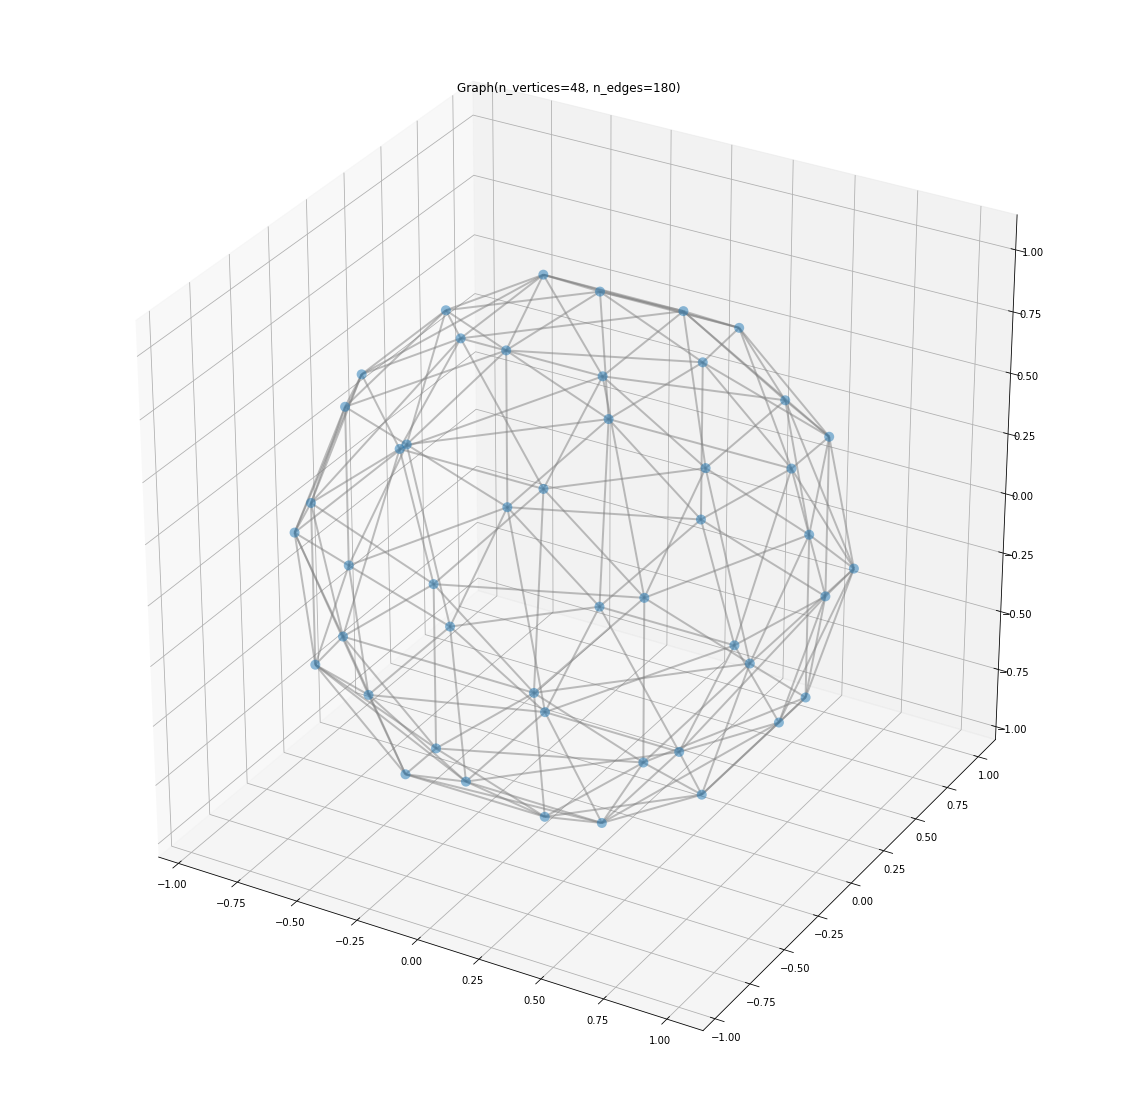

In [16]:
plt.rcParams['figure.figsize'] = (20, 20) # 
utils.healpix_graph(2, dtype=np.float64, std='kernel_width').plot()
plt.savefig('graph.png')


# DeepSphere 1.0

In [ ]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [4, 8, 16]
graphs = []
spectral_content = dict()

for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(utils.healpix_graph(nside, dtype=np.float64, std='kernel_width'))  # in NEST order
    graph = graphs[-1]
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("deepsphere_original.png")
fig2.savefig("deepsphere_original_diagonal.png")

In [ ]:
graph = graphs[-1]
plt.plot(graph.e[:50], 'b.')
plt.plot(graph.e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, graph.e[idx**2] + 0.006, 'l = {}'.format(idx));
plt.savefig('deepsphere_eigenvalues')

# DeepSphere 2.0
### (Thresholded at 0.01)

In [ ]:
plt.rcParams['figure.figsize'] = (17, 5)

nsides = [4, 8, 16]
sigmas = [0.1003, 0.02561, 0.00647, 0.001628]
deepsphere_thresholded_graphs = []
spectral_content = dict()

k= 0.01
 
for nside, sigma in zip(nsides, sigmas):

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=sigma)  # in NEST order
    
    # sparsifying the graph
    W = full_graph.W.copy()
    W[W < k] = 0
    deepsphere_thresholded_graphs.append(pg.graphs.Graph(W))
    graph = deepsphere_thresholded_graphs[-1]
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax, iter=8)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$N_{{side}}={nside}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

fig1.savefig("deepsphere_thresholded.png")
fig2.savefig("deepsphere_thresholded_diagonal.png")

In [ ]:
plt.plot(deepsphere_thresholded_graphs[-1].e[:50], 'b.')
plt.plot(deepsphere_thresholded_graphs[-1].e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, deepsphere_thresholded_graphs[-1].e[idx**2] + 0.03, 'l = {}'.format(idx));
plt.savefig('deepsphere_thresholded_eigenvalues')